In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from os import listdir
from skimage import measure
from PIL import Image, ImageDraw
from IPython.display import display

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [58]:
imlist = sorted(listdir('../data/'))
file = imlist[8]
image = cv2.imread('../data/' + file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

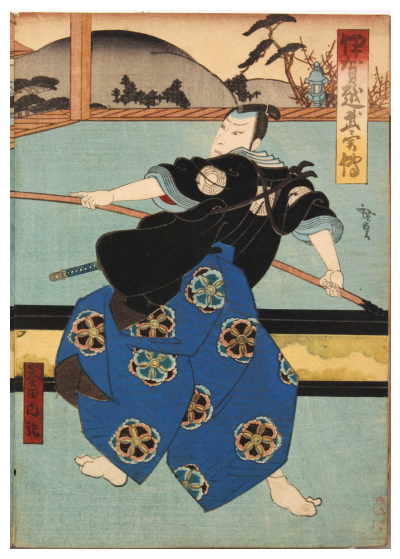

In [59]:
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.axis('off')
plt.show()

In [61]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)


In [96]:
'''model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
'''

"model (Sam): The SAM model to use for mask prediction.\n          points_per_side (int or None): The number of points to be sampled\n            along one side of the image. The total number of points is\n            points_per_side**2. If None, 'point_grids' must provide explicit\n            point sampling.\n          points_per_batch (int): Sets the number of points run simultaneously\n            by the model. Higher numbers may be faster but use more GPU memory.\n          pred_iou_thresh (float): A filtering threshold in [0,1], using the\n            model's predicted mask quality.\n          stability_score_thresh (float): A filtering threshold in [0,1], using\n            the stability of the mask under changes to the cutoff used to binarize\n            the model's mask predictions.\n          stability_score_offset (float): The amount to shift the cutoff when\n            calculated the stability score.\n          box_nms_thresh (float): The box IoU cutoff used by non-maxima

In [112]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10, #32
    pred_iou_thresh=0.86, #0.86
    stability_score_thresh=0.92,
    box_nms_thresh=0.1,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,  # Requires open-cv to run post-processing #100
)

In [113]:
masks2 = mask_generator.generate(image)

In [114]:
len(masks2)

62

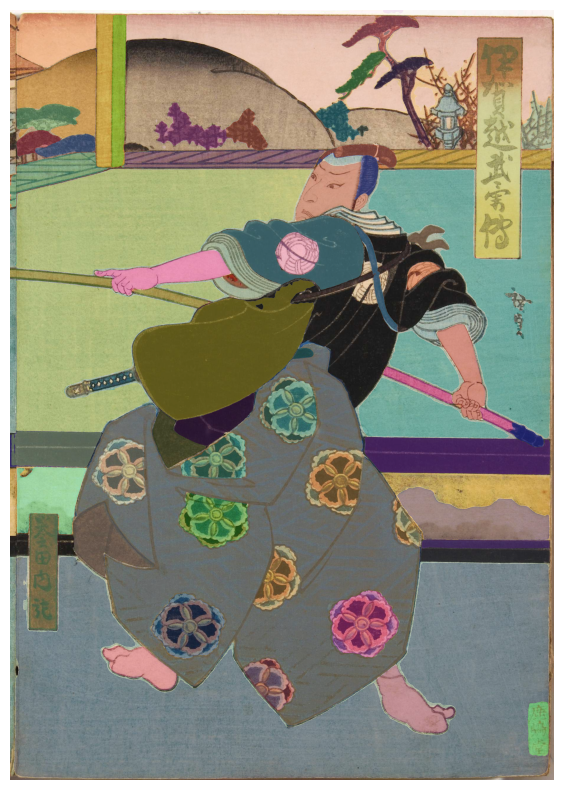

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

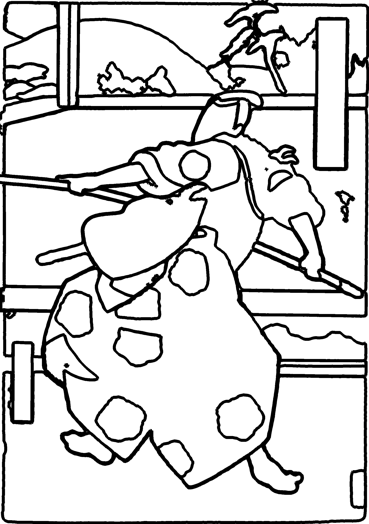

In [116]:
segmented_images = [m['segmentation'] for m in masks2]
# Find the maximum shape
max_shape = np.array([max(im.shape[0] for im in segmented_images), max(im.shape[1] for im in segmented_images)])

# Create a white background image with the same size as the largest image
background = Image.new('L', (max_shape[1], max_shape[0]), color=255)
draw = ImageDraw.Draw(background)

# Loop through each segmented image in the list
for segmented_image in segmented_images:
    # Find contours at a constant value of 0.5
    contours = measure.find_contours(segmented_image, 0.5)
    
    # Draw the contours on the white background
    for contour in contours:
        # Convert contour coordinates to a list of tuples
        contour_coords = [(int(point[1]), int(point[0])) for point in contour]
        # Draw the contour with black color
        draw.line(contour_coords, fill=0, width=15)

# Save the image
background.save('segmented_outlines.png')
resize_factor = 0.2
new_size = (int(background.width * resize_factor), int(background.height * resize_factor))
background_resized = background.resize(new_size)

# Display the resized image in the Jupyter notebook
display(background_resized)
